## Problem 1
Create a routine for calculating an exponentially weighted covariance matrix.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
ret_dat = pd.read_csv("DailyReturn.csv").drop("Unnamed: 0",axis=1)

# Lambda values for exponentially weighted covariance matrix
lambdas = [0.6, 0.7, 0.8, 0.9, 0.97, 0.99]

# Set Seaborn style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("husl", len(lambdas))

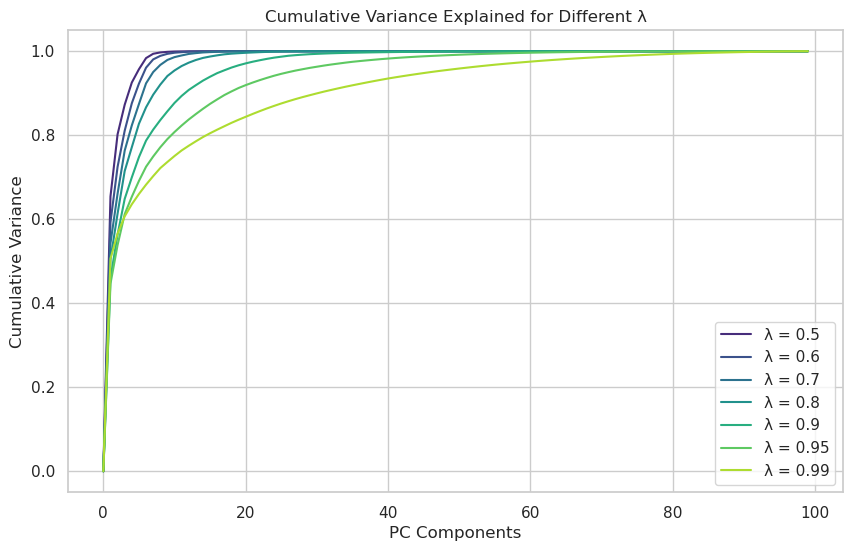

In [20]:
length, num_assets = ret_dat.shape
# Define the function to calculate the exponentially weighted covariance matrix
def compute_ew_cov_matrix(ret_dat, lambda_value):
    length, num_assets = ret_dat.shape
    weights = (1 - lambda_value) * (lambda_value ** np.arange(length)[::-1])
    weights /= weights.sum()
    centered_returns = ret_dat - ret_dat.mean()
    ew_cov_matrix = centered_returns.T @ np.diag(weights) @ centered_returns
    return ew_cov_matrix


# Define the PCA function to calculate cumulative variance explained by eigenvalues
def perform_pca(cov, num_components):
    eigenvalues = np.linalg.eigvalsh(cov)
    eigenvalues = np.sort(eigenvalues)[::-1]
    cum_var_explained = np.sum(eigenvalues[:num_components]) / np.sum(eigenvalues)
    return cum_var_explained


# Select a more comprehensive set of lambda values
lambdas = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

# Use a visually appealing color palette
palette = sns.color_palette("viridis", len(lambdas))

# Generate the Seaborn plot with the updated color palette and lambda values
plt.figure(figsize=(10, 6))
for i, lambda_val in enumerate(lambdas):
    cov_matrix = compute_ew_cov_matrix(ret_dat, lambda_val)
    cum_variances = [perform_pca(cov_matrix, i) for i in range(num_assets)]
    sns.lineplot(x=range(len(cum_variances)), y=cum_variances, label=f"λ = {lambda_val}", color=palette[i])

plt.xlabel("PC Components")
plt.ylabel("Cumulative Variance")
plt.title("Cumulative Variance Explained for Different λ")
plt.legend()
plt.show()